# IBM watsonx.governance evaluation of Agentic App developed using Langgraph

This notebook demonstrates how to use the Agentic AI evaluators from IBM watsonx.governance for governing your applications right in your development environment.

The sample app shown here is an Agentic RAG example for querying information about IBM watsonx.governance capabilities. It makes use of OpenAI's `gpt-4o-mini` LLM for answer generation, and `text-embedding-3-small` embedding model for converting the queries to embeddings. 


### Install the dependencies

In [ ]:
%pip install --quiet "ibm-watsonx-gov[agentic]" chromadb langchain-chroma langchain-openai

Note: you may need to restart the kernel to use updated packages.


### Accept the credentials

The following code snippet ensures that specific environment variables are set without being hardcoded in the script. It does so by prompting the user for input only if the variables are not already set.

The environment variables need to be set are:

1. **OPENAI_API_KEY:** This is required for Open AI capabilities.
2. **WXG_API_KEY:** This is required for IBM watsonx.governance capabilities.

Optionally, if you are using IBM watsonx.governance as a service in a regional data center other than **Dallas (us-south), in Texas US**, you need to set  **WXG_URL**. You can check the regional availability of the watsonx services [here](https://www.ibm.com/docs/en/watsonx/saas?topic=integrations-regional-availability-cloud#regional-availability-of-the-watsonx-services)

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("WXG_API_KEY")

### Set up the local vector store

We have created a local vector store comprising of a few medium posts by [Manish Bhide](https://medium.com/@manish.bhide) and [Ravi Chamarthy](https://medium.com/@ravi-chamarthy). These posts focus on the various capabilities in IBM watsonx.governance (and erstwhile IBM Watson OpenScale). Hence, our queries will focus on these capabilities covered in the above posts. 

For user's convenience, the vector store has been compressed. The following cell downloads the compressed file, extracts it locally, and initializes the Chroma store. 

In [3]:
%rm medium_db.zip
%rm -r medium_db/

!wget https://github.com/IBM/ibm-watsonx-gov/raw/refs/heads/samples/notebooks/data/agentic/medium_db.zip

--2025-03-03 19:56:46--  https://github.com/IBM/ibm-watsonx-gov/raw/refs/heads/samples/notebooks/data/agentic/medium_db.zip
Resolving github.com (github.com)... 20.207.73.82
Connecting to github.com (github.com)|20.207.73.82|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IBM/ibm-watsonx-gov/refs/heads/samples/notebooks/data/agentic/medium_db.zip [following]
--2025-03-03 19:56:47--  https://raw.githubusercontent.com/IBM/ibm-watsonx-gov/refs/heads/samples/notebooks/data/agentic/medium_db.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8001::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1203223 (1.1M) [application/zip]
Saving to: ‘medium_db.zip’

medium_db.zip       100%[===================>]   1.15M  4.57MB/s    in 0.3s    

2

In [4]:
import zipfile

with zipfile.ZipFile("medium_db.zip", "r") as zip_ref:
    zip_ref.extractall(".")

In [5]:
import chromadb
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

client = chromadb.PersistentClient(path="./medium_db")
collection = client.get_or_create_collection("medium_articles")

openai_embed_model = OpenAIEmbeddings(model="text-embedding-3-small")

vector_store = Chroma(
    collection_name="medium_articles",
    embedding_function=openai_embed_model,
    persist_directory="./medium_db"
)

### Set up the State

The `ibm-watsonx-gov` library provides a pydantic based state class. For simple applications, developers can extend this class for their use. 

In [6]:
from ibm_watsonx_gov.entities.state import EvaluationState

class AppState(EvaluationState):
    pass

### Set up the evaluator

For evaluating your Agentic AI applications, you need to first instantiate the `AgenticEvaluation` class. This class defines a few evaluators to compute the different metrics.

We are going to use the following evaluators in this notebook:
1. `evaluate_context_relevance` : To compute context relevance metric of your content retrieval tool.
2. `evaluate_faithfulness`: To compute faithfulness metric of your answer generation tool. This metric does not require ground truth.
3. `evaluate_answer_similarity`: To compute answer similarity metric of your answer generation tool. This metric requires ground truth for computation.


In [7]:
from ibm_watsonx_gov.evaluate.agentic_evaluation import AgenticEvaluation

evaluator = AgenticEvaluation()

/Users/prempiyush/work/code/test_app/.tmp_venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Build your langgraph application

In [8]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langgraph.config import RunnableConfig

#### Define content retrieval node

We are using a Similarity with Threshold Retrieval strategy. This will fetch the top 3 documents matching the query if the threshold score is more than 0.1

The `retrieval_node` tool defined below is decorated with IBM watsonx.governance evaluator `evaluate_context_relevance` tool to compute the context relevance metric. 

In [9]:
@evaluator.evaluate_context_relevance
def retrieval_node(state: AppState, config: RunnableConfig):
    similarity_threshold_retriever = vector_store.as_retriever(search_type="similarity_score_threshold",
                                                               search_kwargs={"k": 3,
                                                                              "score_threshold": 0.1})
    context = similarity_threshold_retriever.invoke(state.input_text)
    return {
        "context": [doc.page_content for doc in context]
    }

#### Define answer generation tool

We are using `gpt-4o-mini` to generate an answer for our query.

The `generate_node` defined below is decorated with two evaluators `evaluate_faithfulness` and `evaluate_answer_similarity` for computing answer quality metrics. 

In [10]:
@evaluator.evaluate_faithfulness
@evaluator.evaluate_answer_similarity
def generate_node(state: AppState, config: RunnableConfig):
    generate_prompt = ChatPromptTemplate.from_template(
        "Answer the following question based on the given context:\n"
        "Context: {context}\n"
        "Question: {input_text}\n"
        "Answer:"
    )

    formatted_prompt = generate_prompt.invoke(
        {"input_text": state.input_text, "context": "\n".join(state.context)})
    llm = ChatOpenAI(model="gpt-4o-mini")
    result = llm.invoke(formatted_prompt)
    return {
        "generated_text": result.content
    }

#### Assemble your application

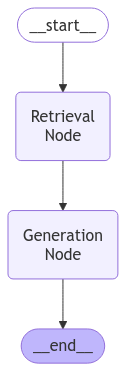

In [11]:
from langgraph.graph import START, END, StateGraph

graph = StateGraph(AppState)

# Add nodes
graph.add_node("Retrieval \nNode", retrieval_node)
graph.add_node("Generation \nNode", generate_node)

# Add edges
graph.add_edge(START, "Retrieval \nNode")
graph.add_edge("Retrieval \nNode", "Generation \nNode")
graph.add_edge("Generation \nNode", END)

# Compile the graph
rag_app = graph.compile()

# Show
from IPython.display import Image, display
display(Image(rag_app.get_graph(xray=True).draw_mermaid_png()))


### Do a single invocation

Now the application is invoked for a single row of data. You will see that a `record_id` key has been added to the inputs. This is required so that IBM watsonx.governance can keep track of individual rows and associate metrics with each row. This will become evident when we do batch invocation in the next cell.

In [12]:
result = rag_app.invoke({"input_text": "What is concept drift?", "ground_truth": "Concept drift occurs when the statistical properties of the target variable change over time, causing a machine learning model’s predictions to become less accurate.", "record_id": "12"})
evaluator.get_metrics_df()

,name,method,value,record_id,tool_name,execution_count
0,answer_similarity,sentence_bert_mini_lm,0.930133,12,generate_node,1
1,faithfulness,sentence_bert_mini_lm,0.258931,12,generate_node,1
2,tool_latency (s),,12.777696,12,generate_node,1
3,context_relevance,sentence_bert_mini_lm,0.182579,12,retrieval_node,1
4,tool_latency (s),,1.730439,12,retrieval_node,1


### Invoke the graph on multiple rows

IBM watsonx.governance evaluation of Agentic Applications can be done with batch invocation too. Here, a dataframe with questions and ground truths for those questions have been defined. The dataframe index has been used as  `record_id` to uniquely identify each row. 

In [13]:
import pandas as pd

question_bank_df = pd.read_csv("https://raw.githubusercontent.com/IBM/ibm-watsonx-gov/refs/heads/samples/notebooks/data/agentic/medium_question_bank.csv")
question_bank_df["record_id"] = question_bank_df.index.astype(str)
question_bank_df

,input_text,ground_truth,record_id
0,What is counterfactual fairness?,Counterfactual fairness is a fairness criterio...,0
1,How does IBM watsonx.governance check for prom...,IBM watsonx.governance runs your prompt throug...,1
2,What are various IBM watsonx.governance capabi...,IBM watsonx.governance is an automated toolkit...,2
3,What does Grafana do?,Grafana is an open-source tool for visualizing...,3
4,What is concept drift?,Concept drift occurs when the statistical prop...,4
5,What does IBM watsonx.governance Evaluation St...,IBM watsonx.governance Evaluation Studio enabl...,5
6,How can technology help in process governance?,"It can help define, automate and govern the pr...",6
7,What are the challenges with AI model validation?,Software execs boast about robust deployment p...,7
8,What are the different steps in AI Lifecycle?,The AI lifecycle consists of several key steps...,8
9,What is Azure Databricks?,"This cloud-based platform, built on Apache Spa...",9


In [14]:
result = rag_app.batch(inputs=question_bank_df.to_dict("records"))
evaluator.get_metrics_df()

,name,method,value,record_id,tool_name,execution_count
0,answer_similarity,sentence_bert_mini_lm,0.921843,0,generate_node,1
1,faithfulness,sentence_bert_mini_lm,0.887591,0,generate_node,1
2,tool_latency (s),,3.420483,0,generate_node,1
3,context_relevance,sentence_bert_mini_lm,0.707973,0,retrieval_node,1
4,tool_latency (s),,0.777236,0,retrieval_node,1
5,answer_similarity,sentence_bert_mini_lm,0.909655,1,generate_node,1
6,faithfulness,sentence_bert_mini_lm,0.783347,1,generate_node,1
7,tool_latency (s),,1.327022,1,generate_node,1
8,context_relevance,sentence_bert_mini_lm,0.706106,1,retrieval_node,1
9,tool_latency (s),,0.936945,1,retrieval_node,1


### CHANGELOG

#### [0.0.1] - 2025-03-01
##### Added
- First set of evaluator nodes from IBM watsonx.governance



Developed by [Prem Piyush Goyal](https://www.linkedin.com/in/prempiyush/)